# **Intrusion Detection & Classification using PySpark**
Dataset used:https://research.unsw.edu.au/projects/unsw-nb15-dataset

---


# **Initiate and Configure Spark**

---


In [ ]:
#Load Spark Engine
import findspark
findspark.init()

#Create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("ML Task using Spark") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "12g")\
    .config("spark.memory.offHeap.enabled",True)\
    .config("spark.memory.offHeap.size","12g")\
    .getOrCreate() 

spark.sparkContext.setLogLevel("ERROR")



# **Load Data**

---


In [2]:
#load feature names from features detail dataset file
features=spark.read.csv('UNSW-NB15_features.csv',inferSchema=True, header =True)
l= list(features.select('Name').toPandas()['Name'])

#load dataset
dataset = spark.read.csv('UNSW-NB15.csv',inferSchema=True, header =False)

#add previously feature names as headers
for i in range(len(l)):
    dataset = dataset.withColumnRenamed('_c'+str(i),l[i])
    
dataset.printSchema
dataset.select('Label','attack_cat').distinct().show()

+-----+---------------+
|Label|     attack_cat|
+-----+---------------+
|    1|          Worms|
|    1|     Shellcode |
|    1|       Analysis|
|    1|            DoS|
|    1|        Generic|
|    1|       Fuzzers |
|    1|       Exploits|
|    0|           null|
|    1|Reconnaissance |
|    1|       Backdoor|
|    1|      Shellcode|
|    1|        Fuzzers|
|    1|      Backdoors|
|    1| Reconnaissance|
+-----+---------------+




# **Data Pre-Processing**

---

In [3]:
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString, VectorIndexer

#as seen above, attack_cat has inconsistencies i.e "Reconnaissance" and "Reconnaissance " are both same category but due to additional space
#it is listed as a separate category. So making this column consistent.
from pyspark.sql.functions import when
dataset=dataset.withColumn("attack_cat",when(dataset.attack_cat=='Reconnaissance ','Reconnaissance').otherwise (dataset.attack_cat))
dataset=dataset.withColumn("attack_cat",when(dataset.attack_cat=='Fuzzers ','Fuzzers').otherwise (dataset.attack_cat))
dataset=dataset.withColumn("attack_cat",when(dataset.attack_cat=='Shellcode ','Shellcode').otherwise (dataset.attack_cat))
dataset=dataset.withColumn("attack_cat",when(dataset.attack_cat=='Backdoors','Backdoor').otherwise (dataset.attack_cat))

#Indexing the string columns
stringCols = [ "proto", "state", "service",'srcip','dstip','attack_cat']    
indexoutputCols  = [x + "_Index" for x in stringCols]
stringIndexer    = StringIndexer(inputCols = stringCols, outputCols = indexoutputCols, handleInvalid = 'keep')
dataset = stringIndexer.fit(dataset).transform(dataset)

dataset.select('Label','attack_cat','attack_cat_Index').distinct().show()

+-----+--------------+----------------+
|Label|    attack_cat|attack_cat_Index|
+-----+--------------+----------------+
|    0|          null|             9.0|
|    1|       Fuzzers|             2.0|
|    1|      Backdoor|             6.0|
|    1|Reconnaissance|             4.0|
|    1|       Generic|             0.0|
|    1|         Worms|             8.0|
|    1|     Shellcode|             7.0|
|    1|      Exploits|             1.0|
|    1|      Analysis|             5.0|
|    1|           DoS|             3.0|
+-----+--------------+----------------+



In [4]:
#combining all the features into one single feature vector and scaling the feature vector.
#removing these columns from the feature vector as some of these are labels and some are already indexed from string
cols=dataset.columns
cols.remove("Label")
cols.remove("attack_cat")
cols.remove("attack_cat_Index")
cols.remove("proto")
cols.remove("state")
cols.remove("service")
cols.remove("srcip")
cols.remove("dstip")


#Let us import the vector assembler and combine features into a single vector called 'features'
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features", handleInvalid="keep")
dataset=assembler.transform(dataset)
#cols.select("features").show(truncate=False)

#Using Standard Scalerizer to scale the feature vector
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(5)




+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[56716.0,143.0,0....|[2.77459021036590...|
|[43467.0,49729.0,...|[2.12643897090723...|
|[41289.0,9574.0,0...|[2.01988954079621...|
|[43785.0,6881.0,2...|[2.14199577475265...|
|[40691.0,6881.0,2...|[1.99063492224415...|
+--------------------+--------------------+
only showing top 5 rows




# **Feature Selection**

---

In [5]:
 
#Feature selection using UniVariateFeatureSelector
from pyspark.ml.feature import UnivariateFeatureSelector
#Feature selection for Binary Classification
selector = UnivariateFeatureSelector(featuresCol="Scaled_features", outputCol="UVSselectedFeatures", labelCol="Label", selectionMode="numTopFeatures")
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)
ds = selector.fit(dataset).transform(dataset)

#Train, test split
train, test = ds.randomSplit([0.8, 0.2], seed=12345)

#Feature selection for MultiClassification
selector1 = UnivariateFeatureSelector(featuresCol="Scaled_features", outputCol="UVSselectedFeatures1",\
                                      labelCol="attack_cat_Index", selectionMode="numTopFeatures")
selector1.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)
ds1 = selector1.fit(dataset).transform(dataset)

#Train, test split
train1, test1 = ds1.randomSplit([0.8, 0.2], seed=12345)

print("UnivariateFeatureSelector output :")
test.select("UVSselectedFeatures").show(5)


UnivariateFeatureSelector output :


+--------------------+
| UVSselectedFeatures|
+--------------------+
|(20,[2,10,16],[8....|
|(20,[2,10,16],[8....|
|(20,[2,10,16],[8....|
|(20,[2,10,16],[8....|
|(20,[2,10,16],[8....|
+--------------------+
only showing top 5 rows



In [15]:
#Balancing the dataset,
dataset_size=float(train.select("Label").count())
ones=train.select("Label").where('Label == 1').count()
ratio_ones=(float(ones)/float(dataset_size))
zeroes=float(dataset_size-ones)
print('The number of ones are :',ones)
print('Ratio of ones to zeroes is :',ratio_ones)
print('The number of zeroes are :',zeroes)

#As clearly seen, number of 'zeroes' are more as compared to number of 'ones' in the dataset, so we add classWeights column to our training dataset
#Formula for Balancing Ratio:

BalancingRatio= zeroes/dataset_size
print('BalancingRatio = ',BalancingRatio)

# Adding the classWeights column
train=train.withColumn("classWeights", when(train.Label == 1,BalancingRatio).otherwise(1-BalancingRatio))

The number of ones are : 257165
Ratio of ones to zeroes is : 0.1265177928791094
The number of zeroes are : 1775474.0
BalancingRatio =  0.8734822071208906


#Feature selection
#Feature selection using VarianceThresholdSelector
from pyspark.ml.feature import VarianceThresholdSelector

selector = VarianceThresholdSelector(varianceThreshold=8.0, outputCol="VTSselectedFeatures")

train = selector.fit(train).transform(train)
test = selector.fit(test).transform(test)

test.select("VTSselectedFeatures").show(5,truncate=False)

Model Accuracy using UVS 0.9896004367116938
FP rate [0.004160752824065205, 0.01663837375251728]
TP rate [0.9833616262474827, 0.9958392471759349]

Model Accuracy using VTS 0.9885388451670243
FP rate [0.004215192580641759, 0.018707117085275213]
TP rate [0.9812928829147247, 0.9957848074193583]

Hence using UVS for feature selection


# **Task 1 - Binary Classifier [20 marks]**

---


In [26]:
# Machine Learning Technique, configuration, etc.:

#Building a classification model using Logistic Regression (LR)

#Import and define Classifier
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Label", featuresCol="UVSselectedFeatures",weightCol="classWeights",maxIter=10)

#Import and define Evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Label")

#Using Cross-Validation to find the best set of parameters in this case we are tuning maxIter parameter
#maxIter defines how many iterations our model ha to do before stopping
from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(lr.maxIter,[10,11,15])
            .build())
lrcv        = CrossValidator(estimator          = lr, 
                           evaluator          = evaluator,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

#train CV Models
lrcvModel     = lrcv.fit(train)

#Predict Label on test Dataset using best CV Model
lrpredictions = lrcvModel.transform(test)

#Calculate acuracy using Area under ROC Curve for evaluation
lraccuracy    = evaluator.evaluate(lrpredictions) 
print("Accuracy of LR Model with UVS Feature Selection = %g " % (lraccuracy))
print("LR Model Results:")
lrpredictions.select("Label","prediction","probability").show(5)
lrbestModel = lrcvModel.bestModel



Accuracy of LR Model with UVS Feature Selection = 0.991512 
LR Model Results:


+-----+----------+--------------------+
|Label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99679498724917...|
|    0|       0.0|[0.99679498724917...|
|    0|       0.0|[0.99679498724917...|
|    0|       0.0|[0.99679498724917...|
|    0|       0.0|[0.99679498724917...|
+-----+----------+--------------------+
only showing top 5 rows



In [28]:
#Building a classification model using Support Vector Machine (SVM)

#Import and define Classifier
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(featuresCol = 'UVSselectedFeatures', labelCol = 'Label', weightCol="classWeights",maxIter=10, regParam=0.1)

#Import and define Evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Label")

#Using Cross-Validation to find the best set of parameters in this case we are tuning regParam parameter
#regParam tells the SVM optimization how much you want to avoid misclassifying each training example
from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(lsvc.regParam,[0.1,0.01])
            .build())

lsvccv        = CrossValidator(estimator          = lsvc, 
                           evaluator          = evaluator,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

#Train CV Models
lsvccvModel     = lsvccv.fit(train)

#Predict Label on test Dataset using best CV Model
lsvcpredictions = lsvccvModel.transform(test)

#Calculate acuracy using Area under ROC Curve for evaluation
lsvcaccuracy    = evaluator.evaluate(lsvcpredictions)
print("Accuracy of SVM Model = %g " % (lsvcaccuracy))
lsvcbestModel = lsvccvModel.bestModel


# Print the coefficients and intercept for linear SVC
#print("Coefficients: " + str(lsvcModel.coefficients))
#print("Intercept: " + str(lsvcModel.intercept))

Accuracy of SVM Model = 0.990165 


In [35]:
#Building a classification model using Support Vector Machine (SVM) without using Feature Selection
#Import and define Classifier
from pyspark.ml.classification import LinearSVC
lsvc2 = LinearSVC(featuresCol = 'Scaled_features', labelCol = 'Label', weightCol="classWeights",maxIter=10, regParam=0.1)

#Import and define Classifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Label")

#Using Cross-Validation to find the best set of parameters in this case we are tuning regParam parameter
#regParam tells the SVM optimization how much you want to avoid misclassifying each training example
from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid2 = (ParamGridBuilder()
            .addGrid(lsvc2.regParam,[0.1,0.01])
            .build())

lsvccv2        = CrossValidator(estimator          = lsvc2, 
                           evaluator          = evaluator,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

#Train CV Models
lsvccvModel2     = lsvccv2.fit(train)

#Predict Label on test Dataset using best CV Model
lsvcpredictions2 = lsvccvModel2.transform(test)

#Calculate accuracy of Model on Test data using Area under ROC Curve for evaluation
lsvcaccuracy2    = evaluator.evaluate(lsvcpredictions2)
print("Accuracy of SVM Model without UVS Feature Selection = %g " % (lsvcaccuracy2))
lsvc2bestModel = lsvccvModel2.bestModel

Accuracy of SVM Model without UVS Feature Selection = 0.990926 


#LR Model without using Feature Selection
lr2 = LogisticRegression(labelCol="Label", featuresCol="Scaled_features",weightCol="classWeights",maxIter=10)

paramGrid2 = (ParamGridBuilder()
            .addGrid(lr2.maxIter,[10,11,15])
            .build())

lr2cv        = CrossValidator(estimator          = lr2, 
                           evaluator          = evaluator,
                           estimatorParamMaps = paramGrid2, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)


lr2cvModel     = lr2cv.fit(train)
lr2predictions = lr2cvModel.transform(test)
lr2accuracy    = evaluator.evaluate(lr2predictions) #using Area under ROC Curve for evaluation

print("Accuracy of LR Model without UVS Feature Selection = %g " % (lr2accuracy))

#Building a classification model using Decision Tree (DT), accuracy is worse than both LR and SVM

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'UVSselectedFeatures', labelCol = 'Label', maxDepth = 5)

from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(dt.maxDepth,[2,12])
            .build())

dtcv        = CrossValidator(estimator          = dt, 
                           evaluator          = evaluator,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

dtcvModel     = dtcv.fit(train)
dtpredictions = dtcvModel.transform(test)
dtaccuracy    = evaluator.evaluate(dtpredictions)
print("Accuracy of Decision Tree Model = %g " % (dtaccuracy))
#dtbestModel = dtcvModel.bestModel
print("DT Model Results:")
predict_test.select("Label","prediction","probability").show(5)



# **Task 2 - Multi Classifier [25 marks]**

---


In [6]:
# Machine Learning Technique, configuration, etc.:
#Building a multiclassification model using Decision Tree (DT)

#Import and define Classifier
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'UVSselectedFeatures1', labelCol = 'attack_cat_Index', maxDepth = 5)

#Import and define Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="attack_cat_Index", predictionCol="prediction")

#Using Cross-Validation to find the best set of parameters in this case we are tuning maxDepth and numTrees parameter
#maxDepth defines maximum depth of each tree

from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(dt.maxDepth,[2,12])
            .build())

dtcv        = CrossValidator(estimator          = dt, 
                           evaluator          = evaluator1,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

#Train CV Models
dtcvModel     = dtcv.fit(train1)

#Predict Label on test Dataset using best CV Model
dtpredictions = dtcvModel.transform(test1)
dtbestModel = dtcvModel.bestModel

#Calculate Accuracy of Model on Test Data using f1 score
dtaccuracy    = evaluator1.evaluate(dtpredictions,{evaluator1.metricName: 'f1'})
print("Accuracy of Decision Tree Model = %g " % (dtaccuracy))

print("DT Model Results:")
dtpredictions.select("attack_cat_Index","prediction","probability").show(5)


Accuracy of Decision Tree Model = 0.977426 
DT Model Results:


+----------------+----------+--------------------+
|attack_cat_Index|prediction|         probability|
+----------------+----------+--------------------+
|             9.0|       9.0|[0.0,0.0,0.0,0.0,...|
|             9.0|       9.0|[0.0,0.0,0.0,0.0,...|
|             9.0|       9.0|[0.0,0.0,0.0,0.0,...|
|             9.0|       9.0|[0.0,0.0,0.0,0.0,...|
|             9.0|       9.0|[0.0,0.0,0.0,0.0,...|
+----------------+----------+--------------------+
only showing top 5 rows



In [7]:
# MultiClassification using RandomForest classifier 

#Import and define Classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'UVSselectedFeatures1', labelCol = 'attack_cat_Index', featureSubsetStrategy="auto")

#Import and define Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="attack_cat_Index", predictionCol="prediction")

#Using Cross-Validation to find the best set of parameters in this case we are tuning maxDepth and numTrees parameter
#maxDepth defines maximum depth of each tree; numTrees defines number of trees to make in the forest
from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth,[4,5,6])
            .addGrid(rf.numTrees,[3,5,10])
            .addGrid(rf.maxBins,[15,20,32]) 
            .build())

rfcv        = CrossValidator(estimator          = rf, 
                           evaluator          = evaluator1,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

#Train CV Models
rfcvModel     = rfcv.fit(train1)
rfcvbestModel = rfcvModel.bestModel

#Predict Label on test Dataset using best CV Model
rfpredictions = rfcvModel.transform(test1)

#Calculate Accuracy of Model on Test Data using f1 score
rfaccuracy    = evaluator1.evaluate(rfpredictions,{evaluator1.metricName: 'f1'})
print("Accuracy of Random Forest Model = %g " % (rfaccuracy))

print("RF Model Results:")
rfpredictions.select("attack_cat_Index","prediction","probability").show(5)

Accuracy of Random Forest Model = 0.968888 
RF Model Results:


+----------------+----------+--------------------+
|attack_cat_Index|prediction|         probability|
+----------------+----------+--------------------+
|             9.0|       9.0|[0.00127176428601...|
|             9.0|       9.0|[0.00127176428601...|
|             9.0|       9.0|[0.00127176428601...|
|             9.0|       9.0|[0.00127176428601...|
|             9.0|       9.0|[0.00127176428601...|
+----------------+----------+--------------------+
only showing top 5 rows



In [8]:
# MultiClassification using logistic Regression

#Import and define Classifier
from pyspark.ml.classification import OneVsRest, LogisticRegression
lr1 = LogisticRegression(maxIter=100,featuresCol="UVSselectedFeatures1", labelCol='attack_cat_Index')
ovr = OneVsRest(classifier=lr1,labelCol='attack_cat_Index', featuresCol='UVSselectedFeatures1')

#Import and define Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="attack_cat_Index", predictionCol="prediction")


#Using Cross-Validation to find the best set of parameters in this case we are tuning maxIter parameter
#maxIter defines how many iterations our model ha to do before stopping
from pyspark.ml.tuning import CrossValidator,  ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(lr1.maxIter,[4,5,6])
            .build())

lr1cv        = CrossValidator(estimator          = ovr, 
                           evaluator          = evaluator1,
                           estimatorParamMaps = paramGrid, 
                           numFolds           = 3, 
                           parallelism        = 4, 
                           seed               = 16)

#Train CV Models
lr1cvModel     = lr1cv.fit(train1)
lr1cvbestModel = lr1cvModel.bestModel

#Predict Label on test Dataset using best CV Model
lr1predictions = lr1cvbestModel.transform(test1)

#Calculate Accuracy of Model on Test Data using f1 score
lr1accuracy    = evaluator1.evaluate(lr1predictions,{evaluator1.metricName: 'f1'})
print("Accuracy of Logistic Regression Model = %g " % (lr1accuracy))

print("LR Model Results:")
lr1predictions.select("attack_cat_Index","prediction",).show(5)

Accuracy of Logistic Regression Model = 0.943906 
LR Model Results:


+----------------+----------+
|attack_cat_Index|prediction|
+----------------+----------+
|             9.0|       9.0|
|             9.0|       9.0|
|             9.0|       9.0|
|             9.0|       9.0|
|             9.0|       9.0|
+----------------+----------+
only showing top 5 rows




# **Task 3 - Performance Measurements [15 marks]**

---


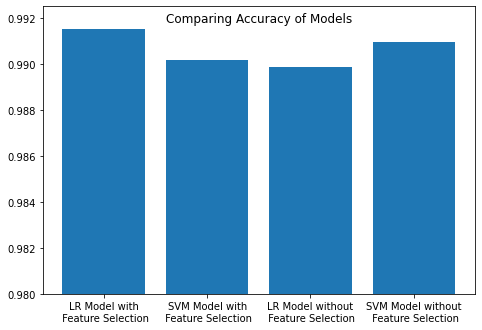

/home/furkhan67/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Model Accuracy using LR 0.9911654782611465
FP rate [0.003406373340075809, 0.014262670137605028]
TP rate [0.9857373298623949, 0.9965936266599241]


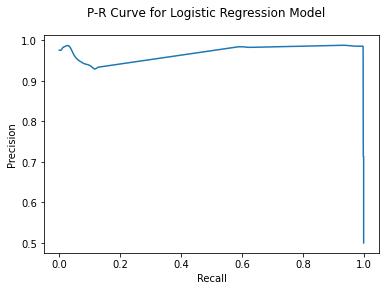

Model Accuracy using SVM 0.9899667953996172
FP rate [0.0017265179942850014, 0.018339891206440966]
TP rate [0.981660108793559, 0.998273482005715]


/home/furkhan67/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


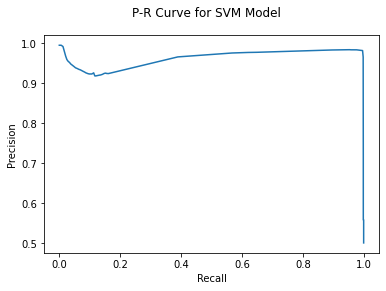

In [36]:
#Binary Classification Performance Measurements

import matplotlib.pyplot as plt
import math
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['LR Model with\n Feature Selection','SVM Model with\n Feature Selection',\
          'LR Model without\n Feature Selection', 'SVM Model without\n Feature Selection']
y = [lraccuracy, lsvcaccuracy, lr2accuracy, lsvcaccuracy2]
plt.ylim([0.98,0.9925])
ax.bar(models,y)
plt.suptitle('Comparing Accuracy of Models')
plt.show()


#LR Model Results 
import matplotlib.pyplot as plt
pr = lrbestModel.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.suptitle('P-R Curve for Logistic Regression Model')

print("Model Accuracy using LR",lrbestModel.summary.accuracy)
print("FP rate",lrbestModel.summary.falsePositiveRateByLabel)
print("TP rate",lrbestModel.summary.truePositiveRateByLabel)
plt.show()

#SVM Model Results 
import matplotlib.pyplot as plt
pr = lsvccvModel.bestModel.summary().pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.suptitle('P-R Curve for SVM Model')

print("Model Accuracy using SVM",lsvccvModel.bestModel.summary().accuracy)
print("FP rate",lsvccvModel.bestModel.summary().falsePositiveRateByLabel)
print("TP rate",lsvccvModel.bestModel.summary().truePositiveRateByLabel)
plt.show()

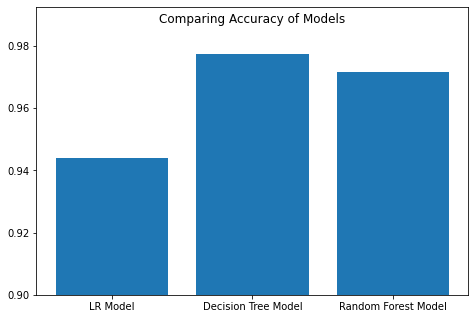

In [11]:
#Multi Classification Performance Measurements
#Plotting bar chart of accuracies of the models
import matplotlib.pyplot as plt
import math
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['LR Model','Decision Tree Model','Random Forest Model']
y = [lr1accuracy, dtaccuracy, rfaccuracy]
plt.ylim([0.9,0.9925])
ax.bar(models,y)
plt.suptitle('Comparing Accuracy of Models')
plt.show()


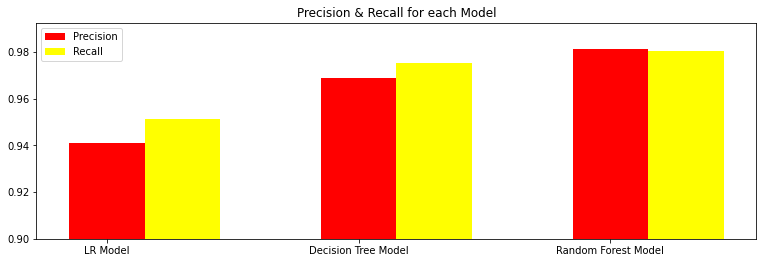

In [10]:
#Calculating Weighted Precision and Recall for each model

lr1Precision = evaluator1.evaluate(lr1predictions, {evaluator1.metricName: "weightedPrecision"})
lr1Recall = evaluator1.evaluate(lr1predictions, {evaluator1.metricName: "weightedRecall"})

dtPrecision = evaluator1.evaluate(dtpredictions, {evaluator1.metricName: "weightedPrecision"})
dtRecall = evaluator1.evaluate(dtpredictions, {evaluator1.metricName: "weightedRecall"})

rfPrecision = evaluator1.evaluate(rfpredictions, {evaluator1.metricName: "weightedPrecision"})
rfRecall = evaluator1.evaluate(rfpredictions, {evaluator1.metricName: "weightedRecall"})
p=[lr1Precision,rfPrecision,dtPrecision]
r=[lr1Recall,rfRecall,dtRecall]

#Plotting bar chart of Weighted Precision and Recall for each model
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(3)
fig = plt.figure(figsize=(10, 3))
models = ['LR Model','Decision Tree Model','Random Forest Model']
ax = fig.add_axes([0,0,1,1])
ax.set_title('Precision & Recall for each Model')
ax.set_xticks(X, models)
plt.ylim([0.9,0.9925])
ax.bar(X + 0, p, color = 'red', width = 0.3, align='center')
ax.bar(X + 0.3, r, color = 'yellow', width = 0.3)
plt.legend(['Precision','Recall'])
plt.show()


#Calculating Precision, Recall for each class in label
x=list(train1.select('attack_cat_Index','attack_cat').distinct().sort('attack_cat_Index').toPandas()['attack_cat'])
x[-1]="Null"
p1={}
r1={}

for i in range(len(x)):
    p1[x[i]]= evaluator1.evaluate(lr1predictions, {evaluator1.metricName: "precisionByLabel", evaluator1.metricLabel: i})
    
for i in range(len(x)):
    r1[x[i]]= evaluator1.evaluate(lr1predictions, {evaluator1.metricName: "recallByLabel", evaluator1.metricLabel: i})
    
#Plotting Precision,Recall
import numpy as np
import matplotlib.pyplot as plt
X = np.arange(10)
fig = plt.figure(figsize=(10, 3))


ax = fig.add_axes([0,0,1,1])
ax.set_title('Precision & Recall by Label for LR Model')
ax.set_xticks(X, x)
fig.autofmt_xdate()


ax.bar(X + 0, list(p1.values()), color = 'red', width = 0.3, align='center')
ax.bar(X + 0.3, list(r1.values()), color = 'yellow', width = 0.3)
plt.legend(['Precision','Recall'])
plt.show()

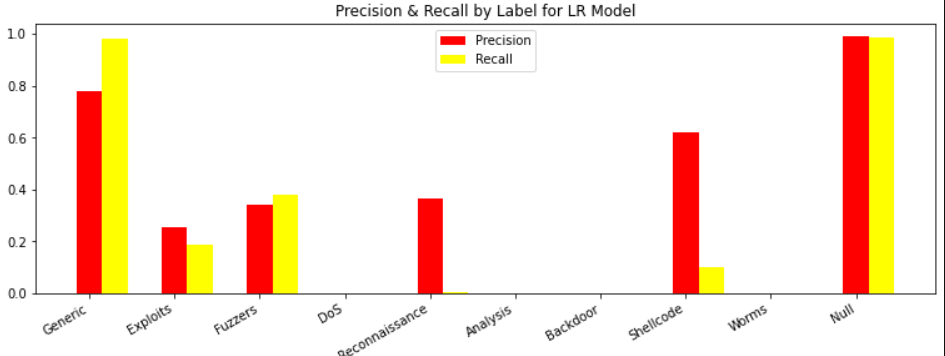
